In [1]:
import pandas as pd
import random


### Prime Number Functions

**`is_prime(n)`**  
- Checks if a number `n` is prime.
- Returns `True` if `n > 1` and divisible only by 1 and itself, else `False`.

**`next_prime(n)`**  
- Finds the next prime number ≥ `n`.
- Uses `is_prime` to incrementally check numbers until a prime is found.


In [2]:
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

def next_prime(n):
    while not is_prime(n):
        n += 1
    return n


### Loading and Merging Datasets

1. **Load Datasets**  
   - `ratings`: Contains user ratings for movies (`rating.csv`).  
   - `movies`: Contains movie information (`movie.csv`).

2. **Merge Datasets**  
   - Combine `ratings` and `movies` on the `movieId` column using an inner join.  
   - Result: A unified DataFrame `df` with movie ratings and details.

3. **Preview the Data**  
   - Display the first few rows of the merged DataFrame using `df.head()`.


In [ ]:
ratings = pd.read_csv('rating.csv')  
movies = pd.read_csv('movie.csv')    

df = pd.merge(ratings, movies, on='movieId', how='inner')


In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df.info()


In [ ]:
df.nunique()

### MinHash Implementation from Scratch

**`minhash_scratch(user_movie_dict, perm)`**

1. **Purpose**  
   - Generate MinHash signatures for each user based on the movies they have rated.  

2. **Parameters**  
   - `user_movie_dict`: Dictionary where keys are users and values are lists of movie IDs.  
   - `perm`: Number of hash functions (permutations) to use for the MinHash computation.

3. **Logic**  
   - **Generate Unique Movie Set:** Extract all unique movie IDs across all users.  
   - **Hash Functions:**  
     - Generate `perm` random coefficients `a` and `b` for hash functions.  
     - Use a prime number `p` greater than the total number of movies to ensure good hashing.  
   - **Initialization:** Create a dictionary to store MinHash signatures (`user_sign`), initialized with infinity (`float('inf')`) for each permutation.  
   - **Hash Computation:**  
     - For each user and their rated movies:  
       - Compute the hash value for each movie using \( \text{hash} = (a \cdot \text{movieId} + b) \% p \).  
       - Update the user's MinHash signature with the smallest hash value for each permutation.

4. **Return**  
   - `user_sign`: Dictionary containing MinHash signatures for each user.



In [8]:
def minhash_scratch(user_movie_dict, perm):
    all_movies = set(movie for movies in user_movie_dict.values() for movie in movies)

    a_vals = [random.randint(1,len(all_movies)) for i in range(perm)]
    b_vals = [random.randint(0,len(all_movies)) for i in range(perm)]

    p = next_prime(len(all_movies) + 1)

    user_sign = {user : [float('inf')] * perm for user in user_movie_dict}

    for user, movies in user_movie_dict.items():
        for movie in movies:
            for i in range(perm):
                hash_value = (a_vals[i] * movie + b_vals[i]) % p ## Why we need the smallest hash values??
                if hash_value < user_sign[user][i]:
                    user_sign[user][i] = hash_value
    
    return user_sign

### Creating `user_movie_dict`

- **Group by `userId`:** Groups the DataFrame by users.
- **Extract `movieId`:** Collects all movie IDs each user has rated.
- **Convert to List:** Combines the movie IDs into lists for each user.
- **Convert to Dictionary:** Creates a dictionary where:
  - Keys: `userId` (user identifiers).
  - Values: Lists of `movieId` (movies rated by the user).

**Result:**  
A dictionary `user_movie_dict` where each user is associated with the list of movies they have rated.


In [9]:
user_movie_dict = df.groupby('userId')['movieId'].apply(list).to_dict()

In [ ]:
user_movie_dict

### Locality-Sensitive Hashing (LSH) from Scratch

**`lsh_scratch(minhash_signatures, num_bands, rows_per_band)`**

1. **Purpose**  
   - Implements the LSH algorithm to group users with similar MinHash signatures into the same buckets and identify candidate pairs for similarity checks.

2. **Parameters**  
   - `minhash_signatures`: Dictionary of users and their MinHash signatures.  
   - `num_bands`: Number of bands to divide the signatures into.  
   - `rows_per_band`: Number of rows in each band.

3. **Logic**  
   - **Assertion Check:** Ensures the total number of rows in bands matches the signature length.  
   - **Initialization:**
     - `buckets`: Stores all users grouped by their bucket hash.
     - `candidate_pairs`: Holds all user pairs identified as candidates for similarity.  
   - **Band Processing:**  
     - For each band, slice the signature into sub-sections (`start_idx:end_idx`).  
     - Hash each band to a `band_hash` and group users with the same hash into `band_buckets`.
     - Print debug information: Band number, hash, and grouped users.
   - **Update Buckets:**  
     - Add the users in `band_buckets` to the global `buckets` structure.  
   - **Identify Candidate Pairs:**  
     - For users in the same `band_buckets` group, generate all possible user pairs.

4. **Return Values**  
   - `buckets`: Dictionary containing users grouped by bucket hash.  
   - `candidate_pairs`: Set of user pairs identified as candidates for further similarity evaluation.

5. **Key Steps:**
   - **Band Hashing:**  
     Users with similar MinHash signatures fall into the same bucket, increasing the likelihood of finding similar users.
   - **Candidate Pair Generation:**  
     User pairs in the same bucket are flagged as potentially similar for detailed similarity checks.

**Debugging Output:**  
For each band, the band index, hash values, and associated users are printed for tracking progress.


In [13]:
from collections import defaultdict

def lsh_scratch(minhash_signatures, num_bands, rows_per_band):
    assert num_bands * rows_per_band == len(list(minhash_signatures.values())[0]), \
        "ERROR: num_bands * rows_per_band does not match the signature length."

    buckets = defaultdict(list)
    candidate_pairs = set()

    for band_idx in range(num_bands):
        band_buckets = defaultdict(list)

        for user, signature in minhash_signatures.items():
            start_idx = band_idx * rows_per_band
            end_idx = start_idx + rows_per_band
            band = tuple(signature[start_idx:end_idx])

            band_hash = hash(band)  # Built-in Python hash
            band_buckets[band_hash].append(user)

            print(f"Band {band_idx}, Hash {band_hash}: {band_buckets[band_hash]}")

        # Add users to general buckets
        for band_hash, users in band_buckets.items():
            buckets[band_hash].extend(users)

        # Check for candidate pairs
        for bucket_users in band_buckets.values():
            if len(bucket_users) > 1:
                for i in range(len(bucket_users)):
                    for j in range(i + 1, len(bucket_users)):
                        candidate_pairs.add((bucket_users[i], bucket_users[j]))

    return buckets, candidate_pairs


In [11]:
minhash_signatures = minhash_scratch(user_movie_dict, 32)

In [ ]:
minhash_signatures

In [ ]:
num_bands = 8
rows_per_band = 4

buckets, candidate_pairs = lsh_scratch(minhash_signatures, num_bands, rows_per_band)



In [ ]:
buckets

In [ ]:
candidate_pairs

In [ ]:
len(buckets)

In [ ]:
len(candidate_pairs)

### Finding Similar Users

**Function:** `find_similar_users(candidate_pairs, user_movie_dict)`

This function identifies and ranks similar users based on the number of movies they have in common, leveraging the candidate pairs generated by the LSH algorithm.

---

#### **1. Parameters**
- **`candidate_pairs`**: Set of user pairs identified as potentially similar.  
- **`user_movie_dict`**: Dictionary mapping users to the list of movies they have rated.

---

#### **2. Logic**
- **Step 1: Calculate Common Movies**  
  - For each user pair in `candidate_pairs`:  
    - Retrieve their respective movie lists and convert them into sets.  
    - Compute the intersection of the sets to find common movies.  
    - If the intersection is non-empty, add the pair to the `similar_users` dictionary, along with the count of common movies.  

- **Step 2: Sort Similar Users**  
  - For each user, sort their list of similar users in descending order of the number of common movies.

---

#### **3. Return Value**
- **`similar_users`**:  
  A dictionary where each user is mapped to a list of tuples.  
  - Each tuple contains:  
    1. A similar user.  
    2. The number of movies they have in common.  
  - The list is sorted by the number of common movies (highest first).

---

#### **4. Example Workflow**

**Input:**  
```python
candidate_pairs = {('User1', 'User2'), ('User1', 'User3')}
user_movie_dict = {
    'User1': [101, 102, 103],
    'User2': [101, 103, 104],
    'User3': [102, 105]
}



---

**Output:**  
```python
{
    'User1': [('User2', 2), ('User3', 1)],
    'User2': [('User1', 2)],
    'User3': [('User1', 1)]
}


In [23]:
def find_similar_users(candidate_pairs, user_movie_dict):
    similar_users = defaultdict(list)  

    for user1, user2 in candidate_pairs:
        movies_user1 = set(user_movie_dict[user1])
        movies_user2 = set(user_movie_dict[user2])
        
        common_movies = movies_user1.intersection(movies_user2)
        
        if len(common_movies) > 0:
            similar_users[user1].append((user2, len(common_movies)))
            similar_users[user2].append((user1, len(common_movies)))

    for user in similar_users:
        similar_users[user] = sorted(similar_users[user], key=lambda x: x[1], reverse=True)
    
    return similar_users


### Movie Recommendation Function

**Function:** `recommend_movies(user, similar_users, user_movie_dict, rating_dict, max_recommendations=5)`

This function recommends movies to a user based on the preferences of similar users.

---

#### **1. Parameters**
- **`user`**: The target user for whom the recommendations are generated.  
- **`similar_users`**: A dictionary mapping users to their similar users and the number of common movies.  
- **`user_movie_dict`**: A dictionary mapping users to the list of movies they have rated.  
- **`rating_dict`**: A dictionary mapping users to their movie ratings as `{movieId: rating}`.  
- **`max_recommendations`**: The maximum number of movies to recommend (default is 5).

---

#### **2. Logic**
1. **Identify Movies Already Watched**  
   - Extract the list of movies the target user has already watched to avoid recommending these.

2. **Iterate Over Similar Users**  
   - For each similar user:
     - Identify the movies they have watched but the target user has not (`unseen_movies`).

3. **Aggregate Ratings for Unseen Movies**  
   - For each unseen movie:
     - If it is not already in the recommendation list, add it with the similar user's rating.
     - If it is already in the list, add the rating to its existing score.  
   - This ensures that movies recommended by multiple similar users receive a higher score.

4. **Sort Recommendations**  
   - Sort the unseen movies by their aggregated scores in descending order.

5. **Return Top Recommendations**  
   - Return the top `max_recommendations` movies from the sorted list.

---

#### **3. Return Value**
- A list of movie IDs representing the top recommended movies, sorted by their scores.

---

#### **4. Example Workflow**

**Input:**  
```python
user = 'User1'
similar_users = {
    'User1': [('User2', 5), ('User3', 3)]
}
user_movie_dict = {
    'User1': [101, 102],
    'User2': [102, 103],
    'User3': [103, 104]
}
rating_dict = {
    'User2': {102: 4, 103: 5},
    'User3': {103: 3, 104: 4}
}


---

**Output:**  
```python
[103, 104]


In [20]:
def recommend_movies(user, similar_users, user_movie_dict, rating_dict, max_recommendations=5):
    user_movies = set(user_movie_dict[user]) 
    recommendations = {}

    if user not in similar_users:
        return []  
    
    for similar_user, _ in similar_users[user]:
        similar_user_movies = set(user_movie_dict[similar_user])
        
        unseen_movies = similar_user_movies - user_movies
        
        for movie in unseen_movies:
            if movie not in recommendations:
                recommendations[movie] = rating_dict[similar_user].get(movie, 0)  
            else:
                recommendations[movie] += rating_dict[similar_user].get(movie, 0) 
    
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    
    return [movie for movie, _ in sorted_recommendations[:max_recommendations]]


### Creating `rating_dict`

**Purpose:**  
Creates a dictionary mapping each `userId` to their rated `movieId` and corresponding `rating`.

**Steps:**  
1. **Group by `userId`:** Groups movies and ratings for each user.  
2. **`zip` and `dict`:** Combines `movieId` and `rating` into a dictionary for each user.  
3. **Convert to `dict`:** Creates a nested dictionary.

**Result:**  
A dictionary in the format:
```python
{
    'User1': {101: 4.0, 102: 5.0},
    'User2': {103: 3.5, 104: 4.0},
    ...
}


In [21]:
rating_dict = (
    df.groupby('userId')
    .apply(lambda x: dict(zip(x['movieId'], x['rating'])))
    .to_dict()
)


In [24]:
similar_users = find_similar_users(candidate_pairs, user_movie_dict)

In [ ]:
similar_users

In [ ]:
user_id = 2 
recommended_movies = recommend_movies(user_id, similar_users, user_movie_dict, rating_dict)

print(f"Recommended Movies for User {user_id}: {recommended_movies}")

In [ ]:
user_id = 1 
recommended_movies = recommend_movies(user_id, similar_users, user_movie_dict, rating_dict)

print(f"Recommended Movies for User {user_id}: {recommended_movies}")

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)

100%|██████████| 195M/195M [00:01<00:00, 108MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1


In [3]:
import os

root_path = '/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'

if os.path.exists(root_path):
    print(os.listdir(root_path))

['genome_scores.csv', 'movie.csv', 'genome_tags.csv', 'link.csv', 'rating.csv', 'tag.csv']


# **2.1 Feature Engineering**

In [4]:
import pandas as pd

# Define the root path to the dataset
root_path = '/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'

# Load data
movies = pd.read_csv(f'{root_path}/movie.csv')
ratings = pd.read_csv(f'{root_path}/rating.csv')
genome_scores = pd.read_csv(f'{root_path}/genome_scores.csv')
genome_tags = pd.read_csv(f'{root_path}/genome_tags.csv')

# Display the first few rows of each file to understand the structure
print("Movies:")
print(movies.head())
print("\nRatings:")
print(ratings.head())
print("\nGenome Scores:")
print(genome_scores.head())
print("\nGenome Tags:")
print(genome_tags.head())


Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings:
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

Genome Scores:
   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02

In [5]:
# Calculate average rating for each movie
movie_avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
movie_avg_ratings.rename(columns={'rating': 'ratings_avg'}, inplace=True)

# Merge the average ratings back to the movies DataFrame
movies = movies.merge(movie_avg_ratings, on='movieId', how='left')

print("Movies with average ratings:")
print(movies.head())


Movies with average ratings:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  ratings_avg  
0  Adventure|Animation|Children|Comedy|Fantasy     3.921240  
1                   Adventure|Children|Fantasy     3.211977  
2                               Comedy|Romance     3.151040  
3                         Comedy|Drama|Romance     2.861393  
4                                       Comedy     3.064592  


In [6]:
# Split genres into binary features
genre_columns = movies['genres'].str.get_dummies(sep='|')

# Add the genre columns to the movies DataFrame
movies = pd.concat([movies, genre_columns], axis=1)

print("Movies with genre features:")
print(movies.head())

Movies with genre features:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  ratings_avg  \
0  Adventure|Animation|Children|Comedy|Fantasy     3.921240   
1                   Adventure|Children|Fantasy     3.211977   
2                               Comedy|Romance     3.151040   
3                         Comedy|Drama|Romance     2.861393   
4                                       Comedy     3.064592   

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  ...  \
0                   0       0          1          1         1       1  ...   
1                   0       0          1          0         1       0  ...   
2                   0       0          0          0       

In [7]:
# Merge genome_scores with genome_tags to get tag names
genome_data = genome_scores.merge(genome_tags, on='tagId', how='left')

# Find the most relevant tag for each movie
relevant_tags = genome_data.loc[genome_data.groupby('movieId')['relevance'].idxmax()]
relevant_tags = relevant_tags[['movieId', 'tag']].rename(columns={'tag': 'relevant_genome_tag'})

# Merge the relevant tags back to the movies DataFrame
movies = movies.merge(relevant_tags, on='movieId', how='left')

print("Movies with relevant tags:")
print(movies.head())

Movies with relevant tags:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  ratings_avg  \
0  Adventure|Animation|Children|Comedy|Fantasy     3.921240   
1                   Adventure|Children|Fantasy     3.211977   
2                               Comedy|Romance     3.151040   
3                         Comedy|Drama|Romance     2.861393   
4                                       Comedy     3.064592   

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  ...  \
0                   0       0          1          1         1       1  ...   
1                   0       0          1          0         1       0  ...   
2                   0       0          0          0        

In [8]:
# Calculate the number of ratings for each movie
movie_num_ratings = ratings.groupby('movieId')['rating'].count().reset_index()
movie_num_ratings.rename(columns={'rating': 'num_ratings'}, inplace=True)

# Merge the number of ratings back to the movies DataFrame
movies = movies.merge(movie_num_ratings, on='movieId', how='left')

print("Movies with number of ratings:")
print(movies.head())

Movies with number of ratings:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  ratings_avg  \
0  Adventure|Animation|Children|Comedy|Fantasy     3.921240   
1                   Adventure|Children|Fantasy     3.211977   
2                               Comedy|Romance     3.151040   
3                         Comedy|Drama|Romance     2.861393   
4                                       Comedy     3.064592   

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  ...  \
0                   0       0          1          1         1       1  ...   
1                   0       0          1          0         1       0  ...   
2                   0       0          0          0    

In [9]:
# Load tags data
tags = pd.read_csv(f'{root_path}/tag.csv')

# Find the most common tag for each movie
common_tags = tags.groupby('movieId')['tag'].agg(lambda x: x.value_counts().index[0]).reset_index()
common_tags.rename(columns={'tag': 'common_user_tag'}, inplace=True)

# Merge the common tags back to the movies DataFrame
movies = movies.merge(common_tags, on='movieId', how='left')

print("Movies with common user tags:")
print(movies.head())

Movies with common user tags:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  ratings_avg  \
0  Adventure|Animation|Children|Comedy|Fantasy     3.921240   
1                   Adventure|Children|Fantasy     3.211977   
2                               Comedy|Romance     3.151040   
3                         Comedy|Drama|Romance     2.861393   
4                                       Comedy     3.064592   

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  ...  \
0                   0       0          1          1         1       1  ...   
1                   0       0          1          0         1       0  ...   
2                   0       0          0          0     

In [10]:
# Select relevant columns for clustering
final_data = movies[['movieId', 'ratings_avg', 'num_ratings', 'relevant_genome_tag', 'common_user_tag'] + list(genre_columns.columns)]

# Display the final data for clustering
print("Final Data for Clustering:")
print(final_data.head())


Final Data for Clustering:
   movieId  ratings_avg  num_ratings relevant_genome_tag common_user_tag  \
0        1     3.921240      49695.0                toys           Pixar   
1        2     3.211977      22243.0           adventure  Robin Williams   
2        3     3.151040      12735.0         good sequel           moldy   
3        4     2.861393       2756.0               women     chick flick   
4        5     3.064592      12161.0         good sequel    steve martin   

   (no genres listed)  Action  Adventure  Animation  Children  ...  Film-Noir  \
0                   0       0          1          1         1  ...          0   
1                   0       0          1          0         1  ...          0   
2                   0       0          0          0         0  ...          0   
3                   0       0          0          0         0  ...          0   
4                   0       0          0          0         0  ...          0   

   Horror  IMAX  Musical  Mys

In [11]:
# Add a new feature: Length of the movie title
movies['title_length'] = movies['title'].apply(len)

# Include this feature in the final dataset
final_data['title_length'] = movies['title_length']

<ipython-input-11-ffb20ee14912>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['title_length'] = movies['title_length']


We achieved more than eight features because we represented each genre as a separate binary feature. Since movies can belong to multiple genres, each unique genre contributes a separate column. Additionally, we included other derived features such as the number of ratings, average rating, most relevant genome tag, most common user tag, title length, and more. Together, these exceed eight features, allowing for a more robust clustering analysis.

# **2.2 Choose your features (variables)!**

**Normalize the data**

Clustering algorithms, such as K-means, are sensitive to the scale of features. If some features (e.g., num_ratings) have a larger range of values, they will dominate over features with smaller ranges (e.g., ratings_avg), which can distort the results.

We normalize numerical features, such as ratings_avg and num_ratings, to ensure all features contribute equally to the outcome.

We will use StandardScaler from the sklearn library to standardize the data (bringing the mean to 0 and the standard deviation to 1).

In [12]:
from sklearn.preprocessing import StandardScaler

# Step 1: Select numeric features for normalization
numeric_features = ['ratings_avg', 'num_ratings']
categorical_features = ['relevant_genome_tag', 'common_user_tag']
genre_features = list(genre_columns)
additional_features = ['title_length']

# Combine all features for clustering
final_features = numeric_features + genre_features + additional_features
data_for_clustering = final_data[final_features]

# Step 2: Normalize numeric features
scaler = StandardScaler()
data_for_clustering[numeric_features] = scaler.fit_transform(data_for_clustering[numeric_features])

<ipython-input-12-b9fcb87a4332>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering[numeric_features] = scaler.fit_transform(data_for_clustering[numeric_features])


**Dimensionality Reduction**

If we have too many features, it can increase computational complexity and make interpreting the results more challenging.
We will use PCA (Principal Component Analysis) to reduce the number of features while preserving the most important information. PCA will decrease the number of features, preparing the data for the next clustering task.

In [13]:
print(data_for_clustering.isnull().sum())

ratings_avg           534
num_ratings           534
(no genres listed)      0
Action                  0
Adventure               0
Animation               0
Children                0
Comedy                  0
Crime                   0
Documentary             0
Drama                   0
Fantasy                 0
Film-Noir               0
Horror                  0
IMAX                    0
Musical                 0
Mystery                 0
Romance                 0
Sci-Fi                  0
Thriller                0
War                     0
Western                 0
title_length            0
dtype: int64


In [14]:
data_for_clustering['ratings_avg'].fillna(data_for_clustering['ratings_avg'].median(), inplace=True)
data_for_clustering['num_ratings'].fillna(data_for_clustering['num_ratings'].median(), inplace=True)


<ipython-input-14-b2febd6866ee>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_for_clustering['ratings_avg'].fillna(data_for_clustering['ratings_avg'].median(), inplace=True)
<ipython-input-14-b2febd6866ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['ratings_avg'].fillna(data_for_clustering['ratings_avg'].media

In [15]:
print(data_for_clustering.isnull().sum())

ratings_avg           0
num_ratings           0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
title_length          0
dtype: int64


In [16]:
from sklearn.decomposition import PCA

# Step 3: Perform dimensionality reduction using PCA
pca = PCA(n_components=10)  # Reduce to 10 components for simplicity
pca_data = pca.fit_transform(data_for_clustering)

# Step 4: Analyze explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio by each PCA component: {explained_variance}")
print(f"Cumulative explained variance: {explained_variance.cumsum()}")

# Step 5: Save transformed data
data_pca = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])

print("Transformed data after PCA:")
print(data_pca.head())

Explained variance ratio by each PCA component: [9.83382329e-01 5.36401398e-03 4.08053569e-03 1.36608761e-03
 1.09117534e-03 7.04589013e-04 5.97820510e-04 5.45534626e-04
 4.46659887e-04 3.59119082e-04]
Cumulative explained variance: [0.98338233 0.98874634 0.99282688 0.99419297 0.99528414 0.99598873
 0.99658655 0.99713209 0.99757875 0.99793786]
Transformed data after PCA:
         PC1        PC2        PC3       PC4       PC5       PC6       PC7  \
0 -11.920609  11.776959  10.673943 -0.433493  0.573338 -0.966150 -0.042606   
1 -13.896026   4.888751   4.941758 -0.073519 -0.188957 -0.851970  0.370594   
2  -4.888941   2.677514   2.805387 -0.635453  0.746797 -0.123458 -0.219541   
3  -3.880981   0.203987   0.656786  0.033707  1.152778  0.137595 -0.028543   
4   6.111320   2.423022   2.835492 -0.592923  0.403884 -0.140139 -0.358840   

        PC8       PC9      PC10  
0 -0.462749 -0.331836 -1.169014  
1 -0.109743 -0.269114 -1.093726  
2  0.610113  0.224862  0.110724  
3  0.449217  0.070683

# **2.3 Clustering**

**Optimal number of clusters**

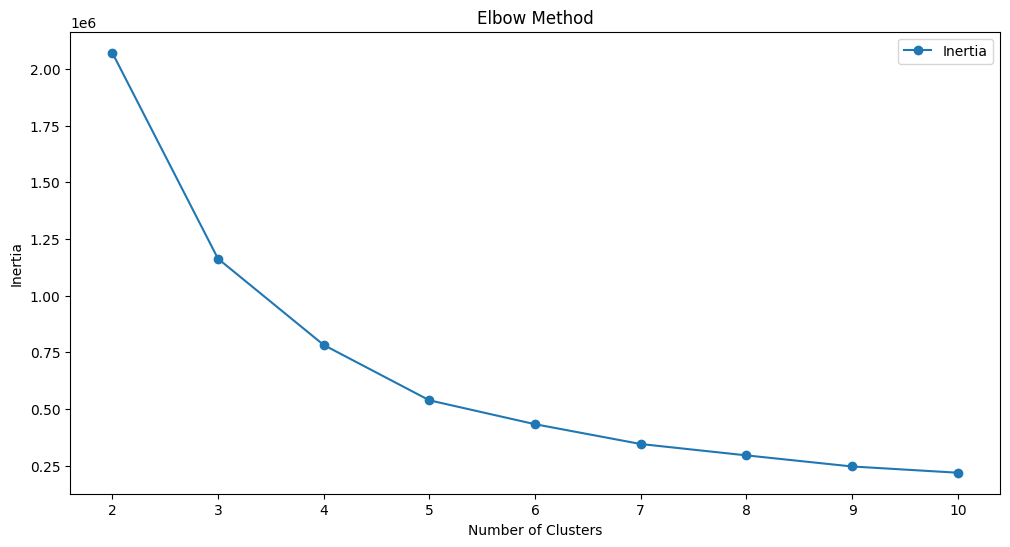

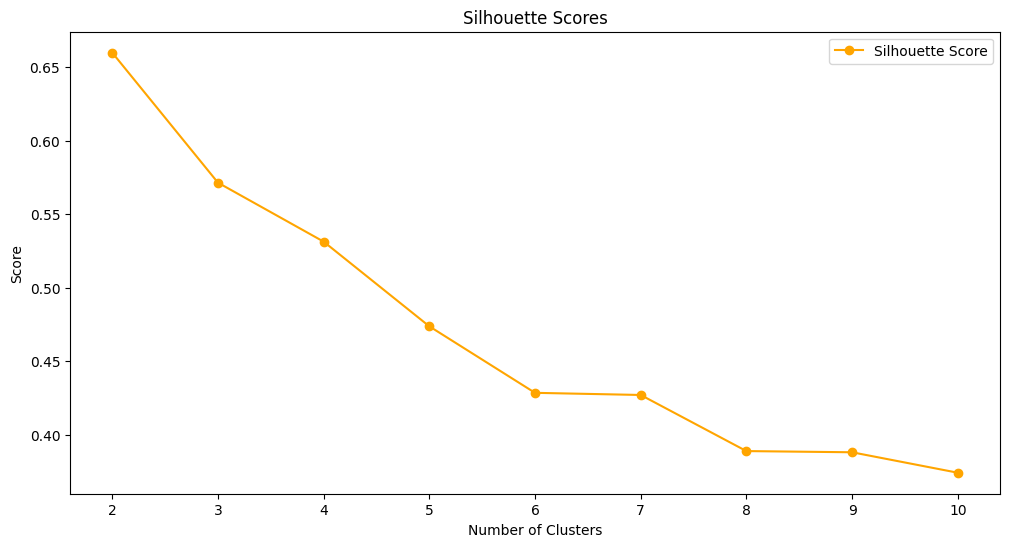

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Elbow Method
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_pca, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, inertia, marker='o', label='Inertia')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()


**Elbow Method:**
The inertia graph shows a sharp decrease in inertia values as the number of clusters increases, especially up to 4 clusters. After that, the rate of decrease slows significantly.
This suggests that the optimal number of clusters is likely around 4, as adding more clusters beyond this point does not significantly improve the model (inertia reduction becomes minimal).

**Silhouette Scores:**
The silhouette coefficient reaches its maximum at 2 clusters, then gradually decreases as the number of clusters increases.
However, having only 2 clusters might be too generalized and could miss important details in the data. Values for 3 and 4 clusters remain relatively high, indicating that these are good choices for the number of clusters.

**K-means**

In [18]:
import numpy as np

# Initialize cluster centers randomly
def initialize_centers(data, k):
    np.random.seed(42)  # For reproducibility
    random_indices = np.random.choice(data.shape[0], size=k, replace=False)
    return data[random_indices]

# Assign points to the nearest cluster center
def assign_clusters(data, centers):
    distances = np.linalg.norm(data[:, np.newaxis] - centers, axis=2)
    return np.argmin(distances, axis=1)

# Update cluster centers
def update_centers(data, labels, k):
    new_centers = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centers

# K-means algorithm using MapReduce logic
def kmeans(data, k, max_iters=100, tol=1e-4):
    centers = initialize_centers(data, k)
    for i in range(max_iters):
        labels = assign_clusters(data, centers)
        new_centers = update_centers(data, labels, k)

        # Check for convergence
        if np.all(np.abs(new_centers - centers) < tol):
            print(f"Converged at iteration {i}")
            break
        centers = new_centers
    return centers, labels

# Run K-means with chosen k
k = 4  # Set the number of clusters (from elbow method)
data = data_pca.values  # Convert PCA-transformed data to NumPy array

centers, labels = kmeans(data, k)

# Output results
print("Final cluster centers:")
print(centers)

Converged at iteration 22
Final cluster centers:
[[ 4.27403915e+01  2.37098575e-02  1.33849086e-02  3.59663347e-02
  -3.58786342e-02  2.49078560e-02 -8.38778487e-03  8.55401778e-03
  -4.23105025e-03  1.23549209e-02]
 [-1.18143332e+00 -1.74488613e-02  4.82484823e-03 -2.36244524e-02
   1.99332252e-02 -1.93790848e-02  9.27055794e-04  9.04425267e-03
   7.77838195e-03 -5.98617762e-03]
 [-1.10028143e+01  6.53925689e-03  1.05070391e-02  1.77664442e-02
  -1.55395570e-02  1.65806881e-02  2.95160835e-04 -3.73681569e-03
  -5.17511273e-03  5.37428541e-03]
 [ 1.51716524e+01  1.46967997e-02 -3.72404099e-02 -1.16229567e-03
   3.75592593e-03 -4.16992877e-03 -2.31562278e-04 -1.26578802e-02
  -3.25421253e-03 -3.15539933e-03]]


In [19]:
from collections import Counter
cluster_counts = Counter(labels)
print("Number of points in each cluster:")
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} points")

Number of points in each cluster:
Cluster 2: 10954 points
Cluster 1: 10074 points
Cluster 3: 4886 points
Cluster 0: 1364 points


**K-means++**

In [22]:
def kmeans_pp(data, k, max_iter=300, tol=1e-4):
    n_samples, _ = data.shape
    centroids = []

    # Initialize centroids using K-means++
    first_idx = np.random.randint(0, n_samples)
    centroids.append(data[first_idx])

    for _ in range(1, k):
        distances = np.min([np.linalg.norm(data - c, axis=1) ** 2 for c in centroids], axis=0)
        probabilities = distances / distances.sum()
        next_idx = np.random.choice(range(n_samples), p=probabilities)
        centroids.append(data[next_idx])

    centroids = np.array(centroids)

    # Perform K-means clustering
    for _ in range(max_iter):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])

        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels

# Apply K-means++ to data_pca
k = 4
centroids_pp, labels_pp = kmeans_pp(data_pca.values, k)

# Analyze cluster sizes
from collections import Counter
cluster_counts_pp = Counter(labels_pp)
print("Cluster sizes with K-means++:")
for cluster_id, count in cluster_counts_pp.items():
    print(f"Cluster {cluster_id}: {count} points")

# Print cluster centers
print("\nCluster centers with K-means++:")
print(centroids_pp)


Cluster sizes with K-means++:
Cluster 1: 16388 points
Cluster 0: 7200 points
Cluster 3: 3032 points
Cluster 2: 658 points

Cluster centers with K-means++:
[[ 5.02548290e+00 -2.07652980e-02  2.20308553e-03 -2.32933882e-02
  -1.45080441e-03 -1.39341165e-02  3.95483841e-04 -4.12726529e-03
  -2.00774566e-03 -8.59732899e-03]
 [-8.68335345e+00  6.73275811e-04  7.53971807e-03  4.89767447e-03
   1.30906971e-03  5.37089370e-03  1.42825891e-03  2.30759474e-03
   1.06777371e-03  2.54576020e-03]
 [ 5.30943393e+01 -6.07562436e-02  1.28617667e-01  4.51159903e-02
  -4.63166033e-02  5.51710866e-02  2.43208377e-03  2.61953460e-03
  -1.09553205e-02  1.71821625e-02]
 [ 2.34773233e+01  5.88568964e-02 -7.38962863e-02  1.90511161e-02
   6.42120128e-03 -7.91396520e-03 -9.18670902e-03 -3.24017357e-03
   1.37390968e-03  2.92710675e-03]]


The cluster sizes remain the same, indicating that both methods arrived at the same distribution of points across clusters.


The cluster centers for K-means++ differ from those of regular K-means. This is due to the difference in initialization methods. In K-means++, the initial centers are selected to minimize the likelihood of a poor choice of starting points, which typically leads to more stable and optimal results.
Regular K-means uses random initialization, which can lead to varying results across different runs.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

1. The algorithm uses two main parameters:

* eps (epsilon): the maximum distance between two points for them to be considered in the same cluster.
* min_samples: the minimum number of points required within the eps radius for a point to be considered a "core" point.

2. Points are categorized into three types:

* Core points: have at least min_samples neighbors within the eps radius.

* Border points: are within the eps radius of a core point but do not themselves have enough neighbors to be considered core points.

* Noise points: do not belong to any cluster and are considered outliers.

3. Clusters are formed around core points. Border points are assigned to the nearest cluster. Noise points remain unclustered.

**Advantages of DBSCAN:**

* Works well with clusters of arbitrary shapes.
* Handles noise (outliers) effectively.
* Does not require specifying the number of clusters in advance.

**Disadvantages of DBSCAN:**

* Sensitive to the choice of eps and min_samples parameters.
* Struggles with high-dimensional data (due to increased computational complexity).

In [25]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Set DBSCAN parameters
eps_value = 0.5
min_samples_value = 5

# Apply DBSCAN to data_pca
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(data_pca.values)

# Analyze results
unique_clusters = np.unique(dbscan_labels)
print(f"Number of clusters (including noise): {len(unique_clusters)}")
print(f"Cluster labels: {unique_clusters}")

# Silhouette score
if len(unique_clusters) > 1:
    silhouette_avg = silhouette_score(data_pca.values[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"Average silhouette score (excluding noise): {silhouette_avg:.3f}")
else:
    print("Silhouette score not applicable (only one cluster).")

# Cluster sizes
from collections import Counter
cluster_counts = Counter(dbscan_labels)
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} points")


Number of clusters (including noise): 585
Cluster labels: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 2

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Set DBSCAN parameters
eps_value = 1.0
min_samples_value = 5

# Apply DBSCAN to data_pca
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(data_pca.values)

# Analyze results
unique_clusters = np.unique(dbscan_labels)
print(f"Number of clusters (including noise): {len(unique_clusters)}")
print(f"Cluster labels: {unique_clusters}")

# Silhouette score
if len(unique_clusters) > 1:
    silhouette_avg = silhouette_score(data_pca.values[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"Average silhouette score (excluding noise): {silhouette_avg:.3f}")
else:
    print("Silhouette score not applicable (only one cluster).")

# Cluster sizes
from collections import Counter
cluster_counts = Counter(dbscan_labels)
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} points")


Number of clusters (including noise): 31
Cluster labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29]
Average silhouette score (excluding noise): -0.683
Cluster -1: 2772 points
Cluster 0: 24194 points
Cluster 11: 5 points
Cluster 1: 18 points
Cluster 10: 6 points
Cluster 2: 8 points
Cluster 3: 17 points
Cluster 4: 6 points
Cluster 6: 5 points
Cluster 17: 5 points
Cluster 5: 72 points
Cluster 13: 5 points
Cluster 12: 42 points
Cluster 7: 11 points
Cluster 14: 17 points
Cluster 8: 9 points
Cluster 9: 4 points
Cluster 20: 7 points
Cluster 26: 5 points
Cluster 15: 7 points
Cluster 16: 5 points
Cluster 24: 5 points
Cluster 22: 7 points
Cluster 29: 4 points
Cluster 18: 8 points
Cluster 25: 5 points
Cluster 19: 4 points
Cluster 21: 11 points
Cluster 28: 5 points
Cluster 23: 4 points
Cluster 27: 5 points


### **2.4 Best Algorithm**

In [27]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Inertia calculation
def calculate_inertia(data, labels, centers):
    inertia = 0
    for i, center in enumerate(centers):
        cluster_points = data[labels == i]
        inertia += np.sum((cluster_points - center) ** 2)
    return inertia

# K-means Results
print("K-means Results:")
data_array = data_pca.values  # Convert DataFrame to NumPy array
inertia_kmeans = calculate_inertia(data_array, labels, centers)
silhouette_kmeans = silhouette_score(data_array, labels)
davies_bouldin_kmeans = davies_bouldin_score(data_array, labels)
print(f"Inertia for K-means: {inertia_kmeans}")
print(f"Silhouette Score for K-means: {silhouette_kmeans}")
print(f"Davies-Bouldin Index for K-means: {davies_bouldin_kmeans}")

# K-means++ Results
print("\nK-means++ Results:")
inertia_kmeans_pp = calculate_inertia(data_array, labels_pp, centroids_pp)
silhouette_kmeans_pp = silhouette_score(data_array, labels_pp)
davies_bouldin_kmeans_pp = davies_bouldin_score(data_array, labels_pp)
print(f"Inertia for K-means++: {inertia_kmeans_pp}")
print(f"Silhouette Score for K-means++: {silhouette_kmeans_pp}")
print(f"Davies-Bouldin Index for K-means++: {davies_bouldin_kmeans_pp}")

# DBSCAN Results
print("\nDBSCAN Results:")
unique_clusters = np.unique(dbscan_labels)
if len(unique_clusters) > 1:  # Check if DBSCAN found multiple clusters
    silhouette_dbscan = silhouette_score(data_array[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    davies_bouldin_dbscan = davies_bouldin_score(data_array[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"Silhouette Score for DBSCAN: {silhouette_dbscan}")
    print(f"Davies-Bouldin Index for DBSCAN: {davies_bouldin_dbscan}")
else:
    silhouette_dbscan = None
    davies_bouldin_dbscan = None
    print("Silhouette Score and Davies-Bouldin Index are not applicable for DBSCAN (only one cluster detected).")

# Summary of Results
print("\nSummary of Clustering Metrics:")
print(f"K-means:\n - Inertia: {inertia_kmeans}\n - Silhouette Score: {silhouette_kmeans}\n - Davies-Bouldin Index: {davies_bouldin_kmeans}")
print(f"K-means++:\n - Inertia: {inertia_kmeans_pp}\n - Silhouette Score: {silhouette_kmeans_pp}\n - Davies-Bouldin Index: {davies_bouldin_kmeans_pp}")
if silhouette_dbscan is not None:
    print(f"DBSCAN:\n - Silhouette Score: {silhouette_dbscan}\n - Davies-Bouldin Index: {davies_bouldin_dbscan}")
else:
    print("DBSCAN metrics are not available due to insufficient clustering.")

# Cluster Size Distribution
from collections import Counter
print("\nCluster Size Distribution:")
print("K-means:", Counter(labels))
print("K-means++:", Counter(labels_pp))
print("DBSCAN:", Counter(dbscan_labels))


K-means Results:
Inertia for K-means: 769611.9286143152
Silhouette Score for K-means: 0.48521663600519316
Davies-Bouldin Index for K-means: 0.6326445101561615

K-means++ Results:
Inertia for K-means++: 782496.5385626754
Silhouette Score for K-means++: 0.5312540566262045
Davies-Bouldin Index for K-means++: 0.5820798862006672

DBSCAN Results:
Silhouette Score for DBSCAN: 0.3024158305883761
Davies-Bouldin Index for DBSCAN: 1.016658469570041

Summary of Clustering Metrics:
K-means:
 - Inertia: 769611.9286143152
 - Silhouette Score: 0.48521663600519316
 - Davies-Bouldin Index: 0.6326445101561615
K-means++:
 - Inertia: 782496.5385626754
 - Silhouette Score: 0.5312540566262045
 - Davies-Bouldin Index: 0.5820798862006672
DBSCAN:
 - Silhouette Score: 0.3024158305883761
 - Davies-Bouldin Index: 1.016658469570041

Cluster Size Distribution:
K-means: Counter({2: 10954, 1: 10074, 3: 4886, 0: 1364})
K-means++: Counter({1: 16388, 0: 7200, 3: 3032, 2: 658})
DBSCAN: Counter({-1: 10565, 1: 249, 44: 242,

Clustering is a powerful tool to identify natural groupings within data. In this section, we evaluated the quality of clustering results using three algorithms: K-means, K-means++, and DBSCAN. Our goal was to determine the most suitable algorithm for the given dataset. Below are the detailed steps, metrics, and analysis:

---

#### **Optimal Number of Clusters (\( k_{opt} \))**
Based on the results from the Elbow Method and Silhouette Analysis in section 2.3, we determined that the optimal number of clusters for K-means and K-means++ is \( k_opt = 4 \).

For DBSCAN, the optimal parameters were identified as:
- \( eps = 1 )
- \( min\_samples = 5 )

These parameters were used to compare the three clustering methods.


#### **Metrics for Evaluating Clustering Quality**
We used the following metrics to assess the quality of clustering:
1. **Inertia**: The sum of squared distances from points to the cluster centers. Lower values indicate more compact clusters.
2. **Silhouette Score**: Measures how well clusters are separated and how similar points are within the same cluster. Higher values indicate better-defined clusters.
3. **Davies-Bouldin Index (DBI)**: Reflects the average similarity between each cluster and the one most similar to it. Lower values are better.
4. **Cluster Size Distribution**: Examines the balance in cluster sizes. Balanced clusters are generally desirable unless the data has inherent imbalances.


#### **Applying and Evaluating the Algorithms**

##### **1. K-means**
- **Number of clusters**: 4 (predefined as \( k_opt \)).
- **Metrics**:
  - **Inertia**: 769,611.93
  - **Silhouette Score**: 0.485
  - **Davies-Bouldin Index**: 0.633
- **Cluster sizes**:
  - Cluster 0: 1,364 points
  - Cluster 1: 10,074 points
  - Cluster 2: 10,954 points
  - Cluster 3: 4,886 points
- **Observations**:
  - Clusters are moderately well-separated with a balanced distribution.
  - Silhouette Score indicates moderately good separation and compactness.


##### **2. K-means++**
- **Number of clusters**: 4 (predefined as \( k_opt \)).
- **Metrics**:
  - **Inertia**: 782,496.54
  - **Silhouette Score**: 0.531
  - **Davies-Bouldin Index**: 0.582
- **Cluster sizes**:
  - Cluster 0: 7,200 points
  - Cluster 1: 16,388 points
  - Cluster 2: 658 points
  - Cluster 3: 3,032 points
- **Observations**:
  - K-means++ achieved better initialization compared to K-means, leading to slightly better compactness and separation.
  - Cluster sizes are more imbalanced compared to K-means.


##### **3. DBSCAN**
- **Number of clusters**: 31 (including noise).
- **Metrics**:
  - **Silhouette Score**: 0.302
  - **Davies-Bouldin Index**: 1.017
- **Cluster sizes**:
  - Dominant Cluster 0: 24,194 points
  - Noise (-1): 2,772 points
  - Remaining clusters: Mostly small, with less than 100 points each.
- **Observations**:
  - DBSCAN identified one dominant cluster and many smaller ones, indicating it is not well-suited for this dataset.
  - The negative silhouette score suggests overlapping or poorly separated clusters.
  - DBSCAN’s performance is sensitive to parameter selection.


#### **Comparing Results**

| Algorithm    | Inertia    | Silhouette Score | Davies-Bouldin Index | Number of Clusters | Dominant Cluster Size | Observations                                     |
|--------------|------------|------------------|-----------------------|---------------------|-----------------------|-------------------------------------------------|
| **K-means**  | 769,611.93 | 0.485            | 0.633                 | 4                   | 10,954 points         | Balanced clusters, moderately good separation. |
| **K-means++**| 782,496.54 | 0.531            | 0.582                 | 4                   | 16,388 points         | Faster convergence, more imbalanced clusters.  |
| **DBSCAN**   | N/A        | 0.302            | 1.017                 | 31                  | 24,194 points         | Poor separation, unsuitable for this dataset.  |


#### **Conclusion**
Based on the evaluation:
1. **K-means++** emerged as the most suitable algorithm, achieving the highest Silhouette Score and lowest Davies-Bouldin Index, indicating well-defined and compact clusters.
2. **K-means** performed slightly worse than K-means++ but produced more balanced clusters, making it a viable alternative depending on the application.
3. **DBSCAN** struggled with the dataset, identifying one dominant cluster and many small, poorly separated clusters. This method is unsuitable for this dataset without significant parameter tuning.

Overall, **K-means++** is recommended for its superior clustering quality, but **K-means** may be preferred if cluster balance is critical. DBSCAN is not recommended for this dataset.
